<a href="https://colab.research.google.com/github/PawelJakubczyk/mln_see_animals_classifier/blob/main/mnl_see_animals_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sorce

https://www.kaggle.com/datasets/vencerlanz09/sea-animals-image-dataste?select=Jelly+Fish

# Install Libraries

In [1]:
%pip install tensorflow
%pip install keras
%pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 715.5 kB/s eta 0:00:00


# Import Libraries

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
from google.colab import drive

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')



# Definine Function

In [15]:
def create_category_image_path_dataframe(folder_path):
    data = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(category_path, filename)
                    data.append({'Category': category, 'Image_Path': image_path})
    df = pd.DataFrame(data)
    return df


def plot_category_counts(df):
    # Counting the number of objects in each category
    category_counts = df['Category'].value_counts()

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', color='skyblue')
    plt.title('Number of objects in each category')
    plt.xlabel('Category')
    plt.ylabel('Number of objects')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Augumentation

In [ ]:
def balance_dataframe(df):
    # Calculate the minimum number of records in a category
    min_records = df['Category'].value_counts().min()

    # Function to remove random records from a group
    def remove_random_records(group):
        return group.sample(n=min_records, random_state=42)

    # Remove random records from the DataFrame
    df_balanced = df.groupby('Category', group_keys=False).apply(remove_random_records)

    return df_balanced

    Rotacja: Obracanie obrazu o losowy kąt może pomóc w zwiększeniu różnorodności danych.

    Przesunięcie poziome/ pionowe: Przesunięcie obrazu w poziomie lub pionie może pomóc w zwiększeniu tolerancji na translację.

    Zoom: Losowe powiększanie lub pomniejszanie obrazu może pomóc w zwiększeniu elastyczności modelu.

    Zmiana jasności/kontrastu: Losowe zmiany jasności i kontrastu mogą pomóc w zwiększeniu odporności modelu na zmiany oświetlenia.

    Rozmycie: Zastosowanie rozmycia Gaussowskiego lub innego rodzaju rozmycia może pomóc w zmniejszeniu nadmiernego dopasowania.

    Elastyczne przekształcenia: Zastosowanie elastycznych przekształceń, takich jak deformacje lokalne, może pomóc w zwiększeniu odporności na zniekształcenia.

    Dodawanie szumu: Dodanie losowego szumu może pomóc w zwiększeniu ogólnej odporności modelu.

    Odbicie lustrzane: Odbicie obrazu w poziomie lub pionie może zwiększyć różnorodność danych.

    Kombinacja kilku technik: Często skuteczne jest zastosowanie kombinacji różnych technik augmentacji w celu uzyskania najlepszych rezultatów.

# Connect to source and get data

In [3]:
drive.mount('/content/drive')

folder = r'/content/drive/MyDrive/colab_assets/sea_animals_archive/'
folder_path = Path(folder)

Mounted at /content/drive


# Process and analyze the data

# Create dataframe

In [11]:
df_animals = create_category_image_path_dataframe(folder_path)
df_animals.head(10)

,Category,Image_Path
0,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
1,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
2,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
3,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
4,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
5,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
6,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
7,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
8,Eel,/content/drive/MyDrive/colab_assets/sea_animal...
9,Eel,/content/drive/MyDrive/colab_assets/sea_animal...


## Augmentation

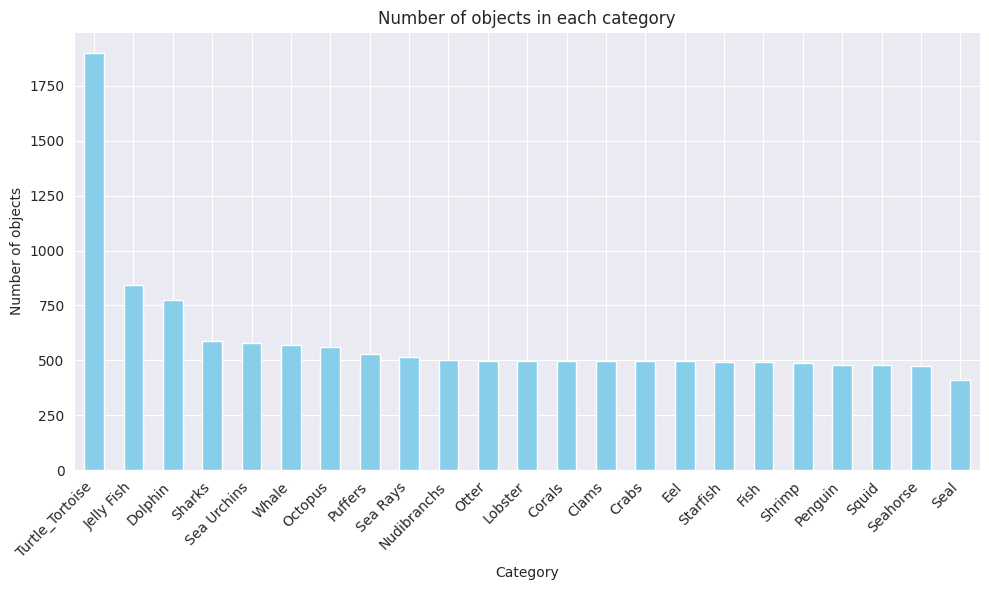

In [16]:
plot_category_counts(df_animals)

In [17]:
df_animals_balance = balance_dataframe(df_animals)

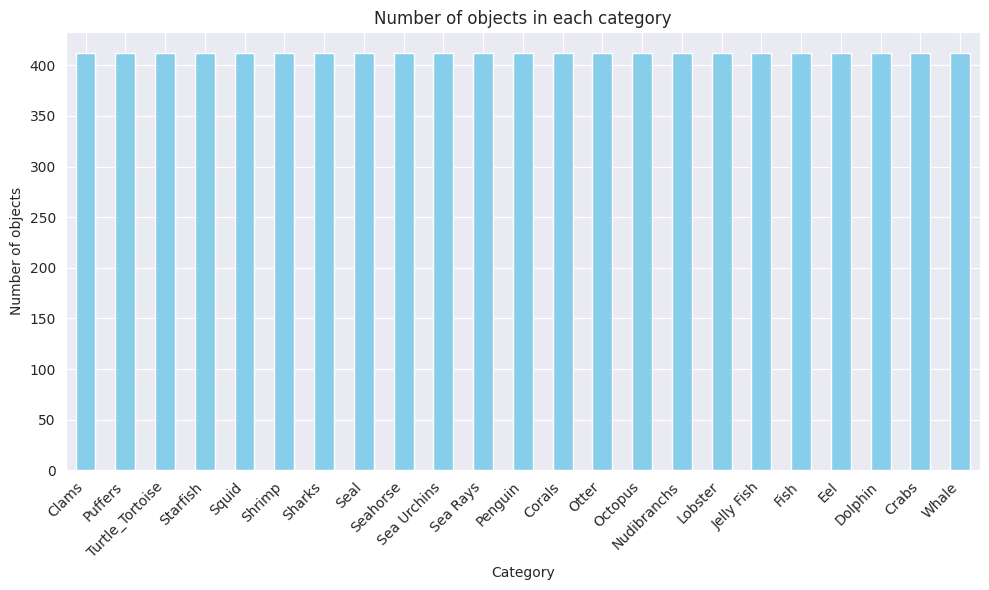

In [18]:
plot_category_counts(df_animals_balance)

In [ ]:


folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

print("folder list: ", folders)